In [93]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import model_selection
from collections import Counter
from imblearn.over_sampling import SMOTE
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
import os
import ast
import dask.dataframe as dd
import pickle

In [94]:
MAIN_PATH = os.path.dirname(os.getcwd())
DATA_PATH = [
                MAIN_PATH + "/data/wrist_result_df.csv" 
            ]

MAX_SEQUENCE_LENGTH = 32
METRIC = ["EDA", "TEMP", "BVP", "X", "Y", "Z"]

## Methods for Plotting with Matplotlib

In this section, we define methods to visualize data distributions using Matplotlib. These methods help in understanding the class distribution before and after applying SMOTE, as well as the distribution of datasets across training, validation, and test sets.

### Plotting Class Distribution Before and After SMOTE

The `plot_smote_class_distribution` function plots the class distribution of the training labels before and after applying SMOTE (Synthetic Minority Over-sampling Technique). This visualization helps in understanding how SMOTE balances the class distribution.


### Plotting Dataset Distribution

The `plot_dataset_distribution` function plots a bar chart showing the sizes of the train, validation, and test sets. This visualization helps in understanding the distribution of samples across different datasets.

These methods provide visual insights into the data, which is crucial for understanding and improving the performance of machine learning models.

In [95]:
def plot_smote_class_distribution(y_train, y_train_resampled):
    """
    Plots the class distribution before and after applying SMOTE.

    Parameters:
    - y_train: Original training labels.
    - y_train_resampled: Training labels after applying SMOTE.
    """
    # Class distribution before SMOTE
    class_distribution_before = Counter(y_train)
    # Class distribution after SMOTE
    class_distribution_after = Counter(y_train_resampled)

    # Define labels
    labels = ['No Stress', 'Stress']

    # Plotting
    plt.figure(figsize=(10, 5))

    # Plot before SMOTE
    plt.subplot(1, 2, 1)
    plt.bar(labels, class_distribution_before.values(), color='blue')
    plt.title('Class Distribution Before SMOTE')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks([0, 1], labels)

    # Plot after SMOTE
    plt.subplot(1, 2, 2)
    plt.bar(labels, class_distribution_after.values(), color='green')
    plt.title('Class Distribution After SMOTE')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks([0, 1], labels)

    plt.tight_layout()
    plt.savefig("../images/preprocessing/SMOTE.png")
    plt.show()
    

In [96]:
def plot_dataset_distribution(x_train_resampled, y_train_resampled, x_val_resampled, y_val_resampled, 
                              x_test_subject_1, y_test_subject_1, 
                              x_test_subject_2, y_test_subject_2):

    dataset_names = ['Train', 'Validation', 'Test Subject 1', 'Test Subject 2']
    # Calculate lengths for x and y datasets
    x_lengths = [len(x_train_resampled), len(x_val_resampled), len(x_test_subject_1), len(x_test_subject_2)]
    y_lengths = [len(y_train_resampled), len(y_val_resampled), len(y_test_subject_1), len(y_test_subject_2)]
    
    # Plotting the bar plot
    plt.figure(figsize=(10, 6))
    
    bar_width = 0.35  # Width of the bars
    index = np.arange(len(dataset_names))
    
    # Create bar plots for x and y datasets
    plt.bar(index, x_lengths, bar_width, color='b', alpha=0.6, label='X (Features)')
    plt.bar(index + bar_width, y_lengths, bar_width, color='r', alpha=0.6, label='Y (Labels)')
    
    plt.xlabel('Dataset')
    plt.ylabel('Number of Samples')
    plt.title('Dataset Distribution')
    plt.xticks(index + bar_width / 2, dataset_names)
    plt.legend()
    
    # Save the figure
    plt.savefig("../images/preprocessing/dataset_distribution.png")
    plt.show()


In [97]:
def read_chunk(file_path, chunk_size, usecols=None, dtype=None):
    """Read a CSV file in chunks and yield DataFrames."""
    for chunk in pd.read_csv(file_path, chunksize=chunk_size, usecols=usecols, dtype=dtype):
        yield chunk

In [98]:
def load_data(file_paths, chunk_size=100000, usecols=None, dtype=None):
    """Load data from multiple CSV files in chunks and concatenate them into a single DataFrame."""
    dataframes = []
    total_files = len(file_paths)

    # Create a thread pool to read files in chunks in parallel
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(read_chunk, file_path, chunk_size, usecols, dtype): file_path for file_path in file_paths}

        for i, future in enumerate(as_completed(futures)):
            file_path = futures[future]
            try:
                # Extend dataframes with the result of read_chunk
                # Assuming read_chunk returns a list of DataFrames
                dataframes.extend(future.result())
                print(f"Completed reading all chunks from {file_path} ({i + 1}/{total_files}).")
            except Exception as e:
                print(f"Error processing chunks from {file_path}: {e}")

    # Concatenate all DataFrames into one and return
    return pd.concat(dataframes, ignore_index=True)


In [99]:
def filter_subjects(df):
    test_df = df[(df['ID'] == 16.0) | (df['ID'] == 17.0)]

    # Drop the filtered rows from the original DataFrame
    sequences_df = df.drop(test_df.index)

    # Reset index for both DataFrames
    test_df.reset_index(drop=True, inplace=True)
    sequences_df.reset_index(drop=True, inplace=True)

    test_subject_1 = test_df[test_df['ID'] == 16.0]
    test_subject_2 = test_df[test_df['ID'] == 17.0]

    # Check if the test subjects DataFrames are empty
    if test_subject_1.empty:
        print("Warning: No data found for test subject 1 (ID 16.0)")
    if test_subject_2.empty:
        print("Warning: No data found for test subject 2 (ID 17.0)")

    return test_subject_1, test_subject_2, sequences_df

In [100]:
def scale_and_flatten(series_list):
    try:
        scaler = MinMaxScaler()
        return [scaler.fit_transform(np.asarray(series).reshape(-1, 1)).flatten() for series in series_list]
    except Exception as e:
        raise ValueError(f"Failed to scale and flatten series: {e}")


In [101]:
def process_metrics(df, t_df1, t_df2):
    try:
        eda_array_list = scale_and_flatten(df[METRIC].apply(eval))
        test_subject1_array_list = scale_and_flatten(t_df1[METRIC].apply(eval))
        test_subject2_array_list = scale_and_flatten(t_df2[METRIC].apply(eval))

        # Print counts
        print(f"EDA list Count: {len(eda_array_list)}\n Test Subject 1: {len(test_subject1_array_list)} \n Test Subject 2: {len(test_subject2_array_list)} ")
        
        return eda_array_list, test_subject1_array_list, test_subject2_array_list
    except Exception as e:
        raise ValueError(f"Failed to process metrics: {e}")


In [102]:
def pad_and_reshape(df, metrics, maxlen):
    try:
        # Initialize a new DataFrame to store the reshaped data
        reshaped_df = pd.DataFrame()

        for metric in metrics:
            if metric in df.columns:
                # Convert the metric column to a list of lists for padding
                series_list = df[metric].tolist()

                # Convert strings to lists if necessary and handle NaN values
                for i in range(len(series_list)):
                    if pd.isna(series_list[i]):
                        series_list[i] = []
                    elif isinstance(series_list[i], str):
                        try:
                            series_list[i] = ast.literal_eval(series_list[i])
                        except Exception as e:
                            raise ValueError(f"Error converting string to list at index {i}: {e}")

                # Pad the series for the current metric
                padded = pad_sequences(series_list, maxlen=maxlen, dtype='float32', padding='post', truncating='post')

                # Convert the padded array to a DataFrame
                reshaped_metric_df = pd.DataFrame(padded, columns=[f'{metric}_{i}' for i in range(maxlen)])
                reshaped_df[metric] = reshaped_metric_df.values.tolist()

        return reshaped_df  # Ensure this returns a DataFrame
    except Exception as e:
        raise ValueError(f"Failed to pad and reshape series: {e}")


In [103]:
def apply_smote(x_train, y_train, x_val, y_val, metrics, max_sequence_length=32, random_state=42):
    # Initialize SMOTE
    smote = SMOTE(random_state=random_state)

    # Resampling for training data
    x_train_array = np.array([np.concatenate([row[i] for i in range(len(metrics))]) for row in x_train.itertuples(index=False)])
    x_resampled, y_resampled = smote.fit_resample(x_train_array, y_train.values.ravel())

    # Create resampled DataFrame for training data
    resampled_data = {metric: [list(x_resampled[i][j * max_sequence_length:(j + 1) * max_sequence_length]) for i in range(len(x_resampled))] for j, metric in enumerate(metrics)}
    x_resampled_df = pd.DataFrame(resampled_data)
    y_resampled_df = pd.DataFrame(y_resampled, columns=['labels'])

    # Resampling for validation data
    x_val_array = np.array([np.concatenate([row[i] for i in range(len(metrics))]) for row in x_val.itertuples(index=False)])
    x_val_resampled, y_val_resampled = smote.fit_resample(x_val_array, y_val.values.ravel())

    # Create resampled DataFrame for validation data
    resampled_val_data = {metric: [list(x_val_resampled[i][j * max_sequence_length:(j + 1) * max_sequence_length]) for i in range(len(x_val_resampled))] for j, metric in enumerate(metrics)}
    x_val_resampled_df = pd.DataFrame(resampled_val_data)
    y_val_resampled_df = pd.DataFrame(y_val_resampled, columns=['labels'])

    return x_resampled_df, y_resampled_df, x_val_resampled_df, y_val_resampled_df


In [104]:
def split_train_and_test(features_df, labels_array, metrics):
    # Prepare DataFrames to hold training and validation features
    x_train = pd.DataFrame()
    x_val = pd.DataFrame()

    # Loop through each metric, splitting the data
    for metric in metrics:
        if metric in features_df.columns:
            # Split the feature for the current metric
            train, val = model_selection.train_test_split(
                features_df[metric], test_size=0.30, random_state=42, shuffle=True
            )
            # Add the split data to the respective DataFrames
            x_train[metric] = train.reset_index(drop=True)  # Resetting index to align
            x_val[metric] = val.reset_index(drop=True)      # Resetting index to align
        else:
            raise ValueError(f"Metric '{metric}' not found in features_df.")

    # Split the labels into training and validation sets
    y_train, y_val = model_selection.train_test_split(
        labels_array, test_size=0.30, random_state=42, shuffle=True
    )

    return x_train, x_val, y_train, y_val  # Ensure these are returned

In [105]:

def extract_labels(df, t_df1, t_df2, label_column='labels'):
    try:
        # Extract labels for the main dataset and test subjects
        labels_array = pd.DataFrame(df[label_column].reset_index(drop=True), columns=[label_column])
        validation_labels_array_subject_1 = pd.DataFrame(t_df1[label_column].reset_index(drop=True), columns=[label_column])
        validation_labels_array_subject_2 = pd.DataFrame(t_df2[label_column].reset_index(drop=True), columns=[label_column])

        print(
            f'Label list Count: {len(labels_array)}\n'
            f"Labels list Count Subject 1: {len(validation_labels_array_subject_1)}\n"
            f"Labels list Count Subject 2: {len(validation_labels_array_subject_2)}"
        )
        
        return labels_array, validation_labels_array_subject_1, validation_labels_array_subject_2
    
    except Exception as e:
        raise ValueError(f"Failed to extract labels: {e}")

In [106]:
def pad_series(eda_array_list, test_subject1_array_list, test_subject2_array_list):
    if not eda_array_list or not test_subject1_array_list or not test_subject2_array_list:
        raise ValueError("Input lists must not be empty")
    
    series_padded = pad_and_reshape(eda_array_list, MAX_SEQUENCE_LENGTH)
    x_test_subject_1_padded = pad_and_reshape(test_subject1_array_list, MAX_SEQUENCE_LENGTH)
    x_test_subject_2_padded = pad_and_reshape(test_subject2_array_list, MAX_SEQUENCE_LENGTH)
    return series_padded, x_test_subject_1_padded, x_test_subject_2_padded


In [107]:
def convert_labels(y_train, y_val, validation_labels_array_subject_1, validation_labels_array_subject_2):
    try:
        y_train = np.asarray(y_train).astype(np.int32)
        y_val = np.asarray(y_val).astype(np.int32)
        y_test_subject_1 = np.asarray(validation_labels_array_subject_1).astype(np.int32)
        y_test_subject_2 = np.asarray(validation_labels_array_subject_2).astype(np.int32)
        return y_train, y_val, y_test_subject_1, y_test_subject_2
    except Exception as e:
        raise ValueError(f"Failed to convert labels: {e}")


In [108]:
def save_datasets(x_train_resampled, y_train_resampled, x_val_resampled, y_val_resampled, 
                  processed_test_subject1_dict, y_test_subject_1, 
                  processed_test_subject2_dict, y_test_subject_2, 
                  save_directory="../data/results/"):
    try:
        # Dictionary to store all datasets
        datasets = {
            "x_train_resampled": x_train_resampled,
            "y_train_resampled": y_train_resampled,
            "x_val_resampled": x_val_resampled,
            "y_val_resampled": y_val_resampled,
            "x_test_subject_1": processed_test_subject1_dict,
            "y_test_subject_1": y_test_subject_1,
            "x_test_subject_2": processed_test_subject2_dict,
            "y_test_subject_2": y_test_subject_2
        }
        
        # Save each dataset as a separate pickle file
        for name, data in datasets.items():
            save_path = f"{save_directory}{name}.pkl"
            with open(save_path, 'wb') as file:
                pickle.dump(data, file)
            print(f"{name} saved successfully to {save_path}")

    except Exception as e:
        raise RuntimeError(f"Failed to save datasets: {e}")


In [109]:
def main():
    df = load_data(DATA_PATH)
    t_df1, t_df2, df = filter_subjects(df)

    # Extract labels and convert to numpy arrays
    labels_array, validation_labels_array_subject_1, validation_labels_array_subject_2 = extract_labels(df, t_df1, t_df2)

    # Pad and reshape metrics
    padded_series = pad_and_reshape(df[METRIC], METRIC, MAX_SEQUENCE_LENGTH)
    x_test_subject_1_padded = pad_and_reshape(t_df1[METRIC], METRIC, MAX_SEQUENCE_LENGTH)
    x_test_subject_2_padded = pad_and_reshape(t_df2[METRIC], METRIC, MAX_SEQUENCE_LENGTH)

    # Ensure padded_series is a DataFrame
    print(f"padded_series shape: {padded_series.shape}, type: {type(padded_series)}")

    # # # Train-test split
    x_train, x_val, y_train, y_val = split_train_and_test(padded_series, labels_array, METRIC)   

    print(f"Train shape: {x_train.shape}, Validation shape: {x_val.shape}")
    print(f"Train labels shape: {y_train.shape}, Validation labels shape: {y_val.shape}")

    # Convert the training and validation labels to DataFrames
    y_train_df = pd.DataFrame(y_train, columns=['labels']).astype(np.int32)
    y_val_df = pd.DataFrame(y_val, columns=['labels']).astype(np.int32)
    y_test_subject_1_df = pd.DataFrame(validation_labels_array_subject_1, columns=['labels']).astype(np.int32)
    y_test_subject_2_df = pd.DataFrame(validation_labels_array_subject_2, columns=['labels']).astype(np.int32)

    # Apply SMOTE
    x_train_resampled, y_train_resampled, x_val_resampled, y_val_resampled= apply_smote(x_train, y_train_df, x_val, y_val_df, METRIC) 
    print(f"Train resampled shape: {x_train_resampled.shape}, Validation resampled shape: {x_val_resampled.shape}")
    print(f"Train resampled labels shape: {y_train_resampled.shape}, Validation resampled labels shape: {y_val_resampled.shape}")

    # Evaluate dataset distribution
    plot_dataset_distribution(x_train_resampled, y_train_resampled, x_val_resampled, y_val_resampled, 
                              x_test_subject_1_padded, y_test_subject_1_df, 
                              x_test_subject_2_padded, y_test_subject_2_df)

    # Save datasets
    save_datasets(x_train_resampled, y_train_resampled, x_val_resampled, y_val_resampled, 
                x_test_subject_1_padded, y_test_subject_1_df, 
                x_test_subject_2_padded, y_test_subject_2_df)    
    
    return df, t_df1, t_df2
    


Completed reading all chunks from d:\Master of Applied IT/data/wrist_result_df.csv (1/1).
Label list Count: 9421
Labels list Count Subject 1: 704
Labels list Count Subject 2: 740
padded_series shape: (9421, 6), type: <class 'pandas.core.frame.DataFrame'>
Train shape: (6594, 6), Validation shape: (2827, 6)
Train labels shape: (6594, 1), Validation labels shape: (2827, 1)
Train resampled shape: (11704, 6), Validation resampled shape: (4998, 6)
Train resampled labels shape: (11704, 1), Validation resampled labels shape: (4998, 1)


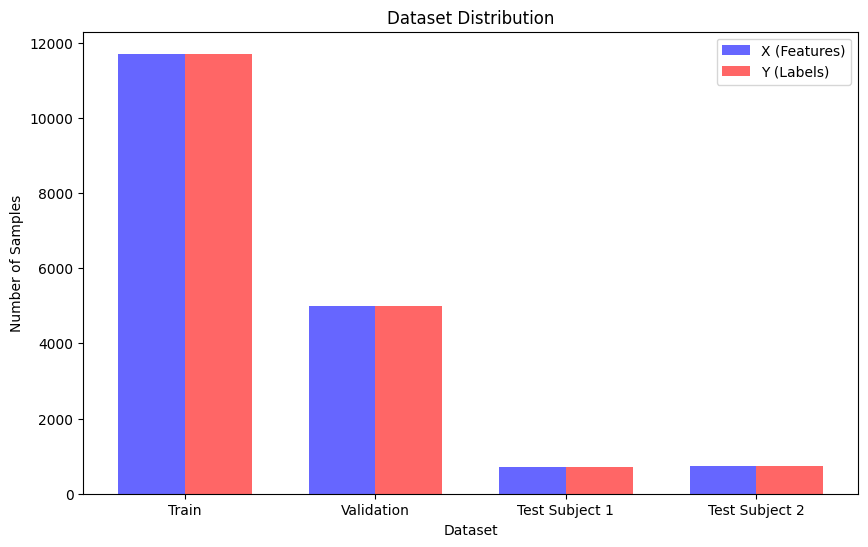

x_train_resampled saved successfully to ../data/results/x_train_resampled.pkl
y_train_resampled saved successfully to ../data/results/y_train_resampled.pkl
x_val_resampled saved successfully to ../data/results/x_val_resampled.pkl
y_val_resampled saved successfully to ../data/results/y_val_resampled.pkl
x_test_subject_1 saved successfully to ../data/results/x_test_subject_1.pkl
y_test_subject_1 saved successfully to ../data/results/y_test_subject_1.pkl
x_test_subject_2 saved successfully to ../data/results/x_test_subject_2.pkl
y_test_subject_2 saved successfully to ../data/results/y_test_subject_2.pkl


(        ID                                                EDA  \
 0      2.0  [1.138257, 1.125444, 1.011405, 1.033188, 0.935...   
 1      2.0  [1.116375, 1.109969, 1.104843, 1.099718, 1.094...   
 2      2.0  [1.249634, 1.261166, 1.267572, 1.270135, 1.275...   
 3      2.0  [1.299606, 1.300887, 1.300887, 1.298324, 1.299...   
 4      2.0  [1.289355, 1.289355, 1.288074, 1.288074, 1.286...   
 ...    ...                                                ...   
 9416  15.0  [0.615586, 0.613028, 0.614307, 0.614307, 0.613...   
 9417  15.0  [0.652685, 0.653964, 0.651405, 0.653964, 0.653...   
 9418  15.0  [0.587443, 0.602794, 0.591281, 0.597677, 0.596...   
 9419  15.0  [0.604073, 0.604073, 0.602794, 0.602794, 0.604...   
 9420  15.0  [0.465914, 0.464635, 0.464635, 0.463355, 0.462...   
 
                                                    TEMP  labels  \
 0     [35.41, 35.41, 35.41, 35.41, 35.41, 35.41, 35....       0   
 1     [35.45, 35.45, 35.45, 35.45, 35.41, 35.41, 35....       0   
 2

In [110]:
main()
